# Retinal Vessel Segmentation using DRIVE Dataset

## Overview
This notebook implements binary retinal vessel segmentation using the DRIVE (Digital Retinal Images for Vessel Extraction) dataset. We will compare two adaptive thresholding methods:
- **Niblack Thresholding**: Local adaptive method
- **Sauvola Thresholding**: Enhanced version of Niblack

## Pipeline:
1. Dataset exploration and loading
2. Image preprocessing (green channel extraction, CLAHE)
3. Vessel segmentation using Niblack and Sauvola
4. Performance evaluation with multiple metrics
5. Parameter optimization
6. Thin vessel analysis using skeletonization
7. Results comparison and visualization

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters, morphology, measure
from pathlib import Path
import os
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd
from scipy import ndimage
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Section 1: Dataset Exploration

Analyze the DRIVE dataset structure and load training images

In [2]:
# Define dataset paths
DATASET_BASE = Path("./archive (2)/DRIVE")
TRAINING_DIR = DATASET_BASE / "training"
IMAGES_DIR = TRAINING_DIR / "images"
MANUAL_MASKS_DIR = TRAINING_DIR / "1st_manual"
VESSEL_MASKS_DIR = TRAINING_DIR / "mask"

print("="*70)
print("DRIVE DATASET STRUCTURE ANALYSIS")
print("="*70)

# Check directory existence
print(f"\nDataset Base Path: {DATASET_BASE}")
print(f"Base Directory Exists: {DATASET_BASE.exists()}")

print(f"\nTraining Images Directory: {IMAGES_DIR}")
print(f"Images Directory Exists: {IMAGES_DIR.exists()}")

print(f"\nManual Vessel Masks (Ground Truth): {MANUAL_MASKS_DIR}")
print(f"Manual Masks Directory Exists: {MANUAL_MASKS_DIR.exists()}")

print(f"\nFOV Masks (Fundus Boundary): {VESSEL_MASKS_DIR}")
print(f"FOV Masks Directory Exists: {VESSEL_MASKS_DIR.exists()}")

# List files in each directory
if IMAGES_DIR.exists():
    image_files = sorted([f for f in os.listdir(IMAGES_DIR) if f.endswith(('.tif', '.png', '.jpg'))])
    print(f"\n✓ Found {len(image_files)} training images:")
    for i, f in enumerate(image_files[:5], 1):
        print(f"  {i}. {f}")
    if len(image_files) > 5:
        print(f"  ... and {len(image_files) - 5} more")

if MANUAL_MASKS_DIR.exists():
    mask_files = sorted([f for f in os.listdir(MANUAL_MASKS_DIR) if f.endswith(('.tif', '.png', '.jpg'))])
    print(f"\n✓ Found {len(mask_files)} manual vessel masks:")
    for i, f in enumerate(mask_files[:5], 1):
        print(f"  {i}. {f}")
    if len(mask_files) > 5:
        print(f"  ... and {len(mask_files) - 5} more")

if VESSEL_MASKS_DIR.exists():
    fov_files = sorted([f for f in os.listdir(VESSEL_MASKS_DIR) if f.endswith(('.tif', '.png', '.jpg'))])
    print(f"\n✓ Found {len(fov_files)} FOV masks (fundus boundary):")
    for i, f in enumerate(fov_files[:5], 1):
        print(f"  {i}. {f}")
    if len(fov_files) > 5:
        print(f"  ... and {len(fov_files) - 5} more")

print("\n" + "="*70)
print("Dataset Structure Summary:")
print("="*70)
if IMAGES_DIR.exists():
    print(f"Training Images: {len(image_files)}")
if MANUAL_MASKS_DIR.exists():
    print(f"Ground Truth Masks: {len(mask_files)}")
if VESSEL_MASKS_DIR.exists():
    print(f"FOV Masks: {len(fov_files)}")

DRIVE DATASET STRUCTURE ANALYSIS

Dataset Base Path: archive (2)\DRIVE
Base Directory Exists: True

Training Images Directory: archive (2)\DRIVE\training\images
Images Directory Exists: True

Manual Vessel Masks (Ground Truth): archive (2)\DRIVE\training\1st_manual
Manual Masks Directory Exists: True

FOV Masks (Fundus Boundary): archive (2)\DRIVE\training\mask
FOV Masks Directory Exists: True

✓ Found 20 training images:
  1. 21_training.tif
  2. 22_training.tif
  3. 23_training.tif
  4. 24_training.tif
  5. 25_training.tif
  ... and 15 more

✓ Found 0 manual vessel masks:

✓ Found 0 FOV masks (fundus boundary):

Dataset Structure Summary:
Training Images: 20
Ground Truth Masks: 0
FOV Masks: 0



Loading 20 training images and masks...
----------------------------------------------------------------------
✓ Loaded: 21_training.tif (Shape: (584, 565, 3))
✓ Loaded: 22_training.tif (Shape: (584, 565, 3))
✓ Loaded: 23_training.tif (Shape: (584, 565, 3))
✓ Loaded: 24_training.tif (Shape: (584, 565, 3))
✓ Loaded: 25_training.tif (Shape: (584, 565, 3))
✓ Loaded: 26_training.tif (Shape: (584, 565, 3))
✓ Loaded: 27_training.tif (Shape: (584, 565, 3))
✓ Loaded: 28_training.tif (Shape: (584, 565, 3))
✓ Loaded: 29_training.tif (Shape: (584, 565, 3))
✓ Loaded: 30_training.tif (Shape: (584, 565, 3))
✓ Loaded: 31_training.tif (Shape: (584, 565, 3))
✓ Loaded: 32_training.tif (Shape: (584, 565, 3))
✓ Loaded: 33_training.tif (Shape: (584, 565, 3))
✓ Loaded: 34_training.tif (Shape: (584, 565, 3))
✓ Loaded: 35_training.tif (Shape: (584, 565, 3))
✓ Loaded: 36_training.tif (Shape: (584, 565, 3))
✓ Loaded: 37_training.tif (Shape: (584, 565, 3))
✓ Loaded: 38_training.tif (Shape: (584, 565, 3))
✓ Load

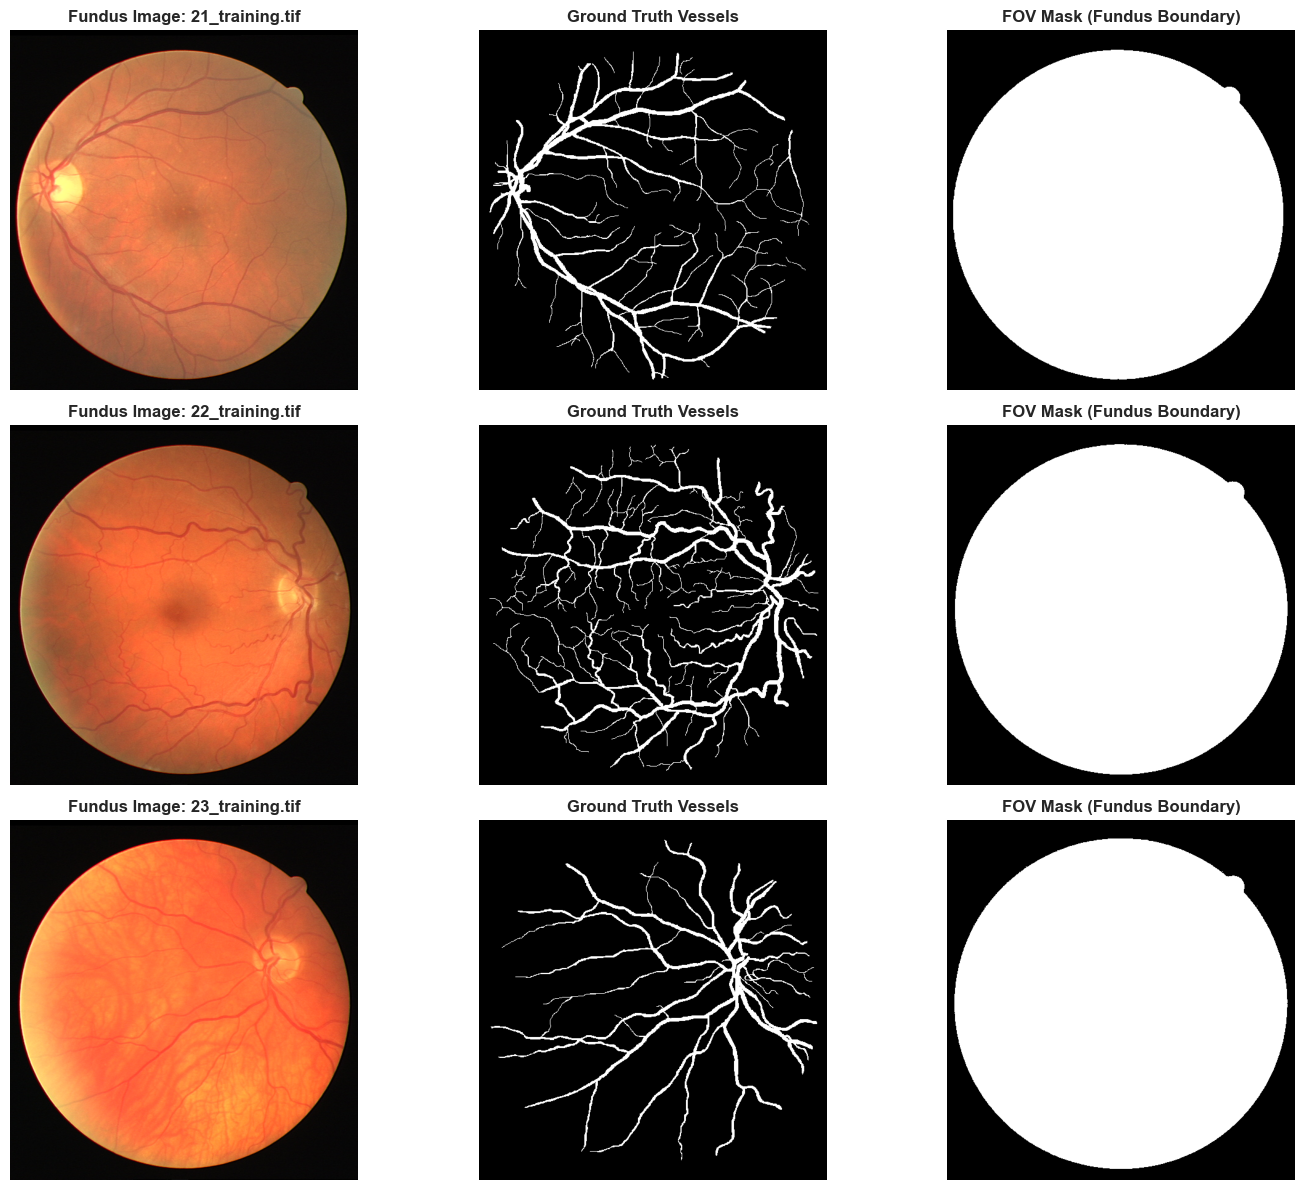

In [3]:
def load_image(image_path):
    """
    Load a retinal fundus image.
    
    Args:
        image_path: Path to the image file
    
    Returns:
        image: Image in RGB format
    """
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb


def load_mask(mask_path):
    """
    Load a binary mask (vessel or FOV mask).
    
    Args:
        mask_path: Path to the mask file
    
    Returns:
        mask: Binary mask (0 or 1)
    """
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None
    
    # Convert to binary (0 or 1)
    mask_binary = (mask > 0).astype(np.uint8)
    return mask_binary


def load_all_training_data():
    """
    Load all training images, manual masks, and FOV masks automatically.
    
    Returns:
        data: Dictionary containing image names and loaded data
    """
    if not IMAGES_DIR.exists():
        print(f"Images directory not found: {IMAGES_DIR}")
        return None
    
    # Get image files
    image_files = sorted([f for f in os.listdir(IMAGES_DIR) if f.endswith(('.tif', '.png', '.jpg'))])
    
    data = {
        'image_names': [],
        'images': [],
        'vessel_masks': [],  # Ground truth
        'fov_masks': []      # Field of view masks
    }
    
    print(f"\nLoading {len(image_files)} training images and masks...")
    print("-"*70)
    
    for img_name in image_files:
        # Load main image
        img_path = IMAGES_DIR / img_name
        try:
            img = load_image(img_path)
            
            # Construct mask filenames (typically same name with different extension/suffix)
            # Format: 05_training.tif -> 05_manual1.gif, 05_training_mask.gif
            base_name = img_name.split('.')[0]
            number = base_name.split('_')[0]
            
            # Load manual vessel mask
            manual_mask_path = MANUAL_MASKS_DIR / f"{number}_manual1.gif"
            if not manual_mask_path.exists():
                # Try alternative naming
                manual_mask_path = MANUAL_MASKS_DIR / f"{base_name}_manual.gif"
            if not manual_mask_path.exists():
                manual_mask_path = MANUAL_MASKS_DIR / f"{number}_manual1.tif"
            
            vessel_mask = load_mask(manual_mask_path) if manual_mask_path.exists() else None
            
            # Load FOV mask
            fov_mask_path = VESSEL_MASKS_DIR / f"{number}_training_mask.gif"
            if not fov_mask_path.exists():
                fov_mask_path = VESSEL_MASKS_DIR / f"{base_name}_mask.gif"
            if not fov_mask_path.exists():
                fov_mask_path = VESSEL_MASKS_DIR / f"{number}_training_mask.tif"
            
            fov_mask = load_mask(fov_mask_path) if fov_mask_path.exists() else None
            
            data['image_names'].append(img_name)
            data['images'].append(img)
            data['vessel_masks'].append(vessel_mask)
            data['fov_masks'].append(fov_mask)
            
            print(f"✓ Loaded: {img_name} (Shape: {img.shape})")
            
        except Exception as e:
            print(f"✗ Error loading {img_name}: {e}")
            continue
    
    print("-"*70)
    print(f"Successfully loaded {len(data['images'])} images")
    
    return data


# Load all training data
training_data = load_all_training_data()

# Display sample images
if training_data and len(training_data['images']) > 0:
    fig, axes = plt.subplots(min(3, len(training_data['images'])), 3, figsize=(15, 12))
    
    if len(training_data['images']) == 1:
        axes = axes.reshape(1, -1)
    elif len(training_data['images']) < 3:
        axes = axes.reshape(len(training_data['images']), -1)
    
    for idx in range(min(3, len(training_data['images']))):
        # Original image
        axes[idx, 0].imshow(training_data['images'][idx])
        axes[idx, 0].set_title(f"Fundus Image: {training_data['image_names'][idx]}", fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Ground truth vessel mask
        if training_data['vessel_masks'][idx] is not None:
            axes[idx, 1].imshow(training_data['vessel_masks'][idx], cmap='gray')
            axes[idx, 1].set_title("Ground Truth Vessels", fontweight='bold')
            axes[idx, 1].axis('off')
        else:
            axes[idx, 1].text(0.5, 0.5, "No Vessel Mask", ha='center', va='center')
            axes[idx, 1].axis('off')
        
        # FOV mask
        if training_data['fov_masks'][idx] is not None:
            axes[idx, 2].imshow(training_data['fov_masks'][idx], cmap='gray')
            axes[idx, 2].set_title("FOV Mask (Fundus Boundary)", fontweight='bold')
            axes[idx, 2].axis('off')
        else:
            axes[idx, 2].text(0.5, 0.5, "No FOV Mask", ha='center', va='center')
            axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

## Section 2: Image Preprocessing

Extract green channel and apply CLAHE (Contrast Limited Adaptive Histogram Equalization)


PREPROCESSING DEMONSTRATION

Processing: 21_training.tif
Original image shape: (584, 565, 3)
Original image dtype: uint8
Original image value range: [0, 255]

Green channel extracted
Green channel value range: [0.00, 255.00]

CLAHE applied with clip_limit=2.0
CLAHE image value range: [0.0039, 1.0000]


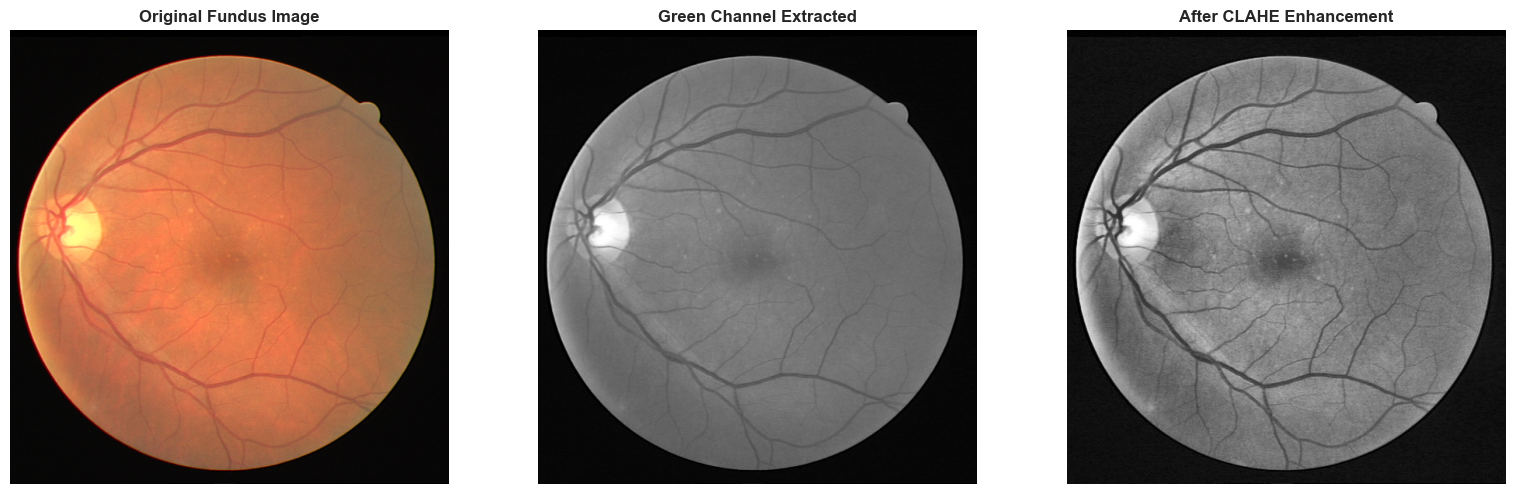

In [4]:
def extract_green_channel(image):
    """
    Extract green channel from RGB fundus image.
    
    The green channel contains the most information about blood vessels
    in a retinal fundus image and provides the best contrast.
    
    Args:
        image: RGB image (H x W x 3)
    
    Returns:
        green_channel: Extracted green channel (H x W)
    """
    # Extract green channel (index 1)
    green_channel = image[:, :, 1].astype(np.float32)
    
    return green_channel


def apply_clahe(image, clip_limit=2.0, tile_size=(8, 8)):
    """
    Apply Contrast Limited Adaptive Histogram Equalization (CLAHE).
    
    CLAHE improves local contrast and prevents over-amplification of noise.
    This is essential for enhancing vessel visibility while maintaining details.
    
    Args:
        image: Grayscale input image (H x W)
        clip_limit: Threshold for contrast limiting (default 2.0)
        tile_size: Size of grid for local histogram equalization (default 8x8)
    
    Returns:
        clahe_image: CLAHE enhanced image
    """
    # Normalize to 0-255 range if not already
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    # Create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    
    # Apply CLAHE
    clahe_image = clahe.apply(image)
    
    # Normalize to 0-1 range
    clahe_normalized = clahe_image.astype(np.float32) / 255.0
    
    return clahe_normalized


def preprocess_image(image, apply_clahe_enhancement=True, clip_limit=2.0):
    """
    Complete preprocessing pipeline for retinal image.
    
    Steps:
    1. Extract green channel
    2. Apply CLAHE for contrast enhancement
    3. Normalize to 0-1 range
    
    Args:
        image: RGB fundus image
        apply_clahe_enhancement: Whether to apply CLAHE
        clip_limit: CLAHE clip limit parameter
    
    Returns:
        processed_image: Preprocessed grayscale image
    """
    # Extract green channel
    green = extract_green_channel(image)
    
    # Apply CLAHE
    if apply_clahe_enhancement:
        processed = apply_clahe(green, clip_limit=clip_limit)
    else:
        # Just normalize
        processed = green / 255.0
    
    return processed


# Demonstrate preprocessing on first image
if training_data and len(training_data['images']) > 0:
    print("\n" + "="*70)
    print("PREPROCESSING DEMONSTRATION")
    print("="*70)
    
    sample_image = training_data['images'][0]
    print(f"\nProcessing: {training_data['image_names'][0]}")
    print(f"Original image shape: {sample_image.shape}")
    print(f"Original image dtype: {sample_image.dtype}")
    print(f"Original image value range: [{sample_image.min()}, {sample_image.max()}]")
    
    # Extract green channel
    green_channel = extract_green_channel(sample_image)
    print(f"\nGreen channel extracted")
    print(f"Green channel value range: [{green_channel.min():.2f}, {green_channel.max():.2f}]")
    
    # Apply CLAHE
    clahe_image = apply_clahe(green_channel, clip_limit=2.0)
    print(f"\nCLAHE applied with clip_limit=2.0")
    print(f"CLAHE image value range: [{clahe_image.min():.4f}, {clahe_image.max():.4f}]")
    
    # Visualize preprocessing steps
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    axes[0].imshow(sample_image)
    axes[0].set_title("Original Fundus Image", fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(green_channel, cmap='gray')
    axes[1].set_title("Green Channel Extracted", fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(clahe_image, cmap='gray')
    axes[2].set_title("After CLAHE Enhancement", fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

## Section 3: Adaptive Thresholding Methods

Implement Niblack and Sauvola thresholding for vessel segmentation


THRESHOLDING DEMONSTRATION

Niblack Thresholding (window=25, k=0.2):
  Vessel pixels: 128019 (38.80%)
  After FOV mask: 75661

Sauvola Thresholding (window=25, k=0.2):
  Vessel pixels: 45870 (13.90%)
  After FOV mask: 13404


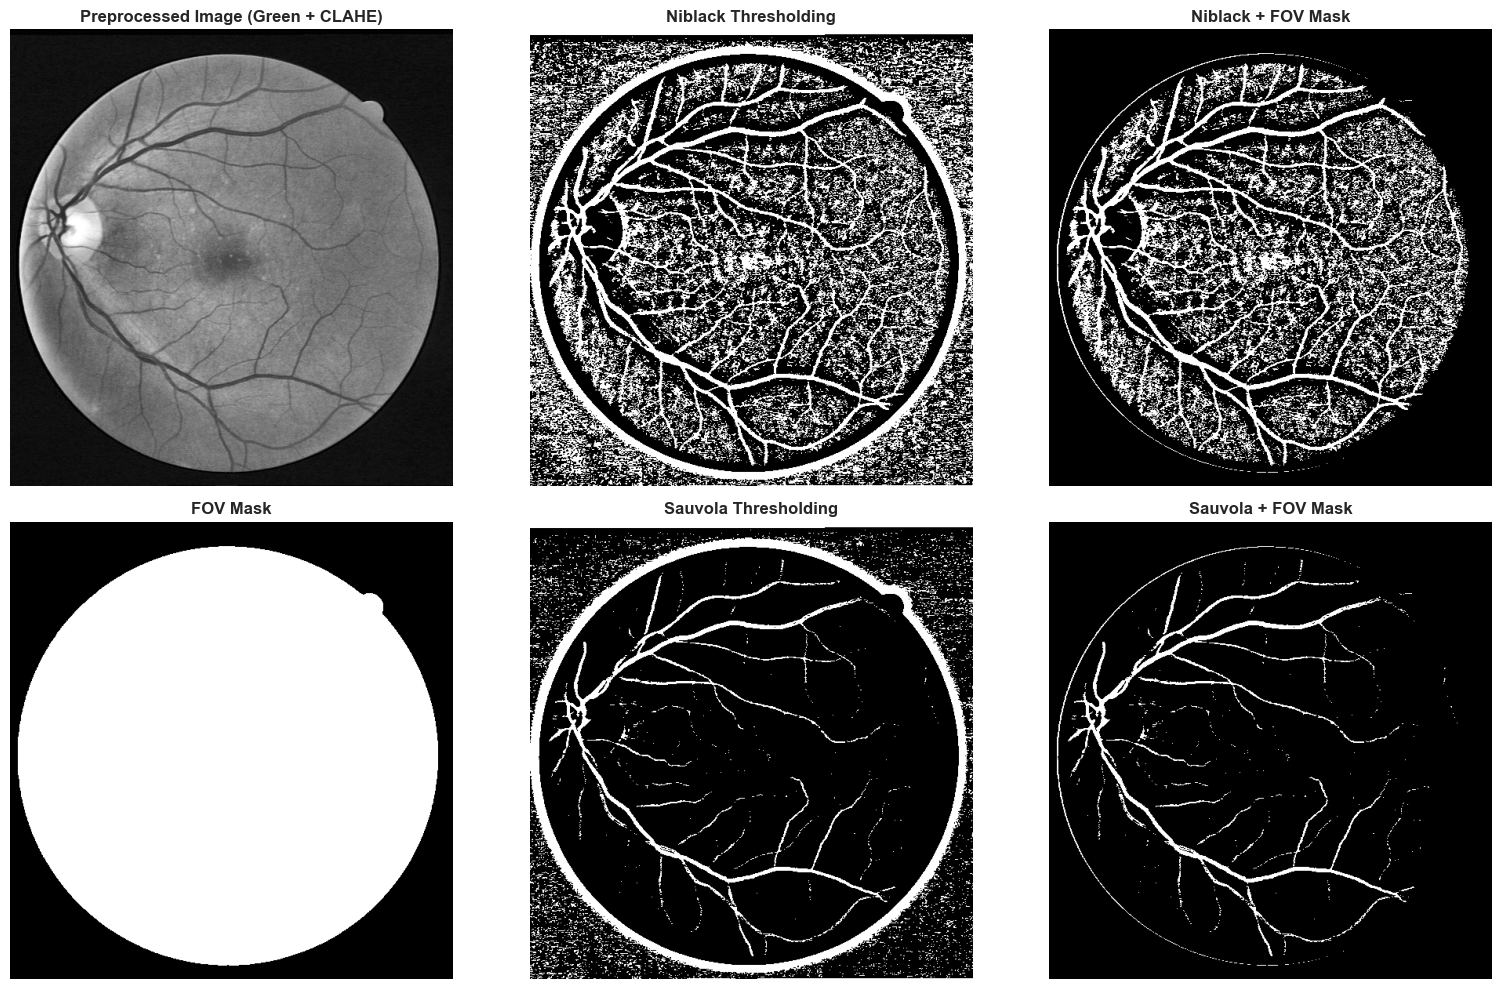

In [5]:
def niblack_threshold(image, window_size=25, k=0.2):
    """
    Niblack Thresholding - Adaptive local thresholding method.
    
    Threshold(x,y) = mean(x,y) - k * std(x,y)
    
    Objects are typically darker than background, so pixels darker than 
    the local threshold are classified as foreground (vessels).
    
    Args:
        image: Input image (normalized to 0-1 range)
        window_size: Size of local window (must be odd)
        k: Coefficient for standard deviation weighting (typically 0.1-0.5)
    
    Returns:
        binary_image: Binary segmentation (1 = vessel, 0 = background)
    """
    # Ensure window_size is odd
    if window_size % 2 == 0:
        window_size += 1
    
    # Use scikit-image implementation
    threshold = filters.threshold_niblack(image, window_size=window_size, k=k)
    
    # Apply threshold (inverted because vessels are darker)
    binary = (image < threshold).astype(np.uint8)
    
    return binary


def sauvola_threshold(image, window_size=25, k=0.2, r=None):
    """
    Sauvola Thresholding - Enhanced version of Niblack.
    
    Threshold(x,y) = mean(x,y) * (1 + k * ((std(x,y) - R) / R))
    
    Where R is typically the dynamic range divided by 2.
    Sauvola improves on Niblack by considering the standard deviation range.
    
    Args:
        image: Input image (normalized to 0-1 range)
        window_size: Size of local window (must be odd)
        k: Parameter controlling threshold response to local contrast
        r: Normalization factor (if None, computed as max_value/2)
    
    Returns:
        binary_image: Binary segmentation (1 = vessel, 0 = background)
    """
    # Ensure window_size is odd
    if window_size % 2 == 0:
        window_size += 1
    
    if r is None:
        r = 128  # Standard value for 8-bit images
    
    # Use scikit-image implementation
    threshold = filters.threshold_sauvola(image, window_size=window_size, k=k, r=r)
    
    # Apply threshold (inverted because vessels are darker)
    binary = (image < threshold).astype(np.uint8)
    
    return binary


def apply_mask_to_segmentation(segmentation, fov_mask):
    """
    Apply FOV (Field of View) mask to segmentation.
    
    Only evaluate pixels within the fundus region defined by FOV mask.
    
    Args:
        segmentation: Binary segmentation image
        fov_mask: Binary mask defining fundus region (1 = inside FOV, 0 = outside)
    
    Returns:
        masked_segmentation: Segmentation with FOV mask applied
    """
    if fov_mask is None:
        return segmentation
    
    # Apply mask: set to 0 outside FOV
    masked = segmentation * fov_mask
    
    return masked


# Demonstrate thresholding methods on sample image
if training_data and len(training_data['images']) > 0:
    print("\n" + "="*70)
    print("THRESHOLDING DEMONSTRATION")
    print("="*70)
    
    sample_image = training_data['images'][0]
    sample_fov_mask = training_data['fov_masks'][0]
    
    # Preprocess
    preprocessed = preprocess_image(sample_image, apply_clahe_enhancement=True)
    
    # Apply both thresholding methods
    niblack_result = niblack_threshold(preprocessed, window_size=25, k=0.2)
    sauvola_result = sauvola_threshold(preprocessed, window_size=25, k=0.2)
    
    # Apply FOV mask
    niblack_masked = apply_mask_to_segmentation(niblack_result, sample_fov_mask)
    sauvola_masked = apply_mask_to_segmentation(sauvola_result, sample_fov_mask)
    
    print(f"\nNiblack Thresholding (window=25, k=0.2):")
    print(f"  Vessel pixels: {np.sum(niblack_result)} ({np.sum(niblack_result)/niblack_result.size*100:.2f}%)")
    print(f"  After FOV mask: {np.sum(niblack_masked)}")
    
    print(f"\nSauvola Thresholding (window=25, k=0.2):")
    print(f"  Vessel pixels: {np.sum(sauvola_result)} ({np.sum(sauvola_result)/sauvola_result.size*100:.2f}%)")
    print(f"  After FOV mask: {np.sum(sauvola_masked)}")
    
    # Visualize results
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Row 1
    axes[0, 0].imshow(preprocessed, cmap='gray')
    axes[0, 0].set_title("Preprocessed Image (Green + CLAHE)", fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(niblack_result, cmap='gray')
    axes[0, 1].set_title("Niblack Thresholding", fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(niblack_masked, cmap='gray')
    axes[0, 2].set_title("Niblack + FOV Mask", fontweight='bold')
    axes[0, 2].axis('off')
    
    # Row 2
    axes[1, 0].imshow(sample_fov_mask, cmap='gray')
    axes[1, 0].set_title("FOV Mask", fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(sauvola_result, cmap='gray')
    axes[1, 1].set_title("Sauvola Thresholding", fontweight='bold')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(sauvola_masked, cmap='gray')
    axes[1, 2].set_title("Sauvola + FOV Mask", fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

## Section 4: Performance Metrics

Calculate sensitivity, accuracy, precision, and F1 score

In [6]:
def calculate_metrics(predicted, ground_truth, fov_mask=None):
    """
    Calculate segmentation performance metrics.
    
    Metrics:
    - Sensitivity (Recall/TPR): fraction of true vessels detected
    - Accuracy: fraction of correctly classified pixels
    - Precision: fraction of predicted vessels that are correct
    - F1 Score: Harmonic mean of precision and recall
    
    Args:
        predicted: Binary segmentation (1 = vessel, 0 = background)
        ground_truth: Ground truth binary mask
        fov_mask: Optional FOV mask (only evaluate inside FOV)
    
    Returns:
        metrics: Dictionary with all calculated metrics
    """
    # Apply FOV mask if provided
    if fov_mask is not None:
        inside_fov = fov_mask > 0
        predicted_masked = predicted[inside_fov]
        ground_truth_masked = ground_truth[inside_fov]
    else:
        predicted_masked = predicted.flatten()
        ground_truth_masked = ground_truth.flatten()
    
    # Calculate confusion matrix elements
    tp = np.sum((predicted_masked == 1) & (ground_truth_masked == 1))  # True Positive
    fp = np.sum((predicted_masked == 1) & (ground_truth_masked == 0))  # False Positive
    tn = np.sum((predicted_masked == 0) & (ground_truth_masked == 0))  # True Negative
    fn = np.sum((predicted_masked == 0) & (ground_truth_masked == 1))  # False Negative
    
    # Calculate metrics
    sensitivity = tp / (tp + fn + 1e-7)  # Same as recall/TPR
    specificity = tn / (tn + fp + 1e-7)  # True Negative Rate
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-7)
    precision = tp / (tp + fp + 1e-7)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-7)
    
    metrics = {
        'sensitivity': sensitivity,
        'specificity': specificity,
        'accuracy': accuracy,
        'precision': precision,
        'f1_score': f1,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn
    }
    
    return metrics


def evaluate_segmentation(images_list, masks_list, fov_masks_list, 
                          window_size=25, k=0.2, method='niblack'):
    """
    Evaluate segmentation method on multiple images.
    
    Args:
        images_list: List of RGB fundus images
        masks_list: List of ground truth vessel masks
        fov_masks_list: List of FOV masks
        window_size: Threshold window size
        k: Threshold k parameter
        method: 'niblack' or 'sauvola'
    
    Returns:
        results: List of metric dictionaries for each image
        segmentations: List of segmented images
    """
    results = []
    segmentations = []
    
    print(f"\nEvaluating {method.upper()} (window={window_size}, k={k})...")
    print("-" * 70)
    
    for idx, (image, mask, fov_mask) in enumerate(zip(images_list, masks_list, fov_masks_list)):
        try:
            # Skip if no mask
            if mask is None:
                print(f"Skipping image {idx+1}: No ground truth mask")
                continue
            
            # Preprocess
            preprocessed = preprocess_image(image, apply_clahe_enhancement=True)
            
            # Apply thresholding
            if method == 'niblack':
                segmented = niblack_threshold(preprocessed, window_size=window_size, k=k)
            else:  # sauvola
                segmented = sauvola_threshold(preprocessed, window_size=window_size, k=k)
            
            # Apply FOV mask
            if fov_mask is not None:
                segmented = apply_mask_to_segmentation(segmented, fov_mask)
            
            # Calculate metrics
            metrics = calculate_metrics(segmented, mask, fov_mask=fov_mask)
            
            results.append(metrics)
            segmentations.append(segmented)
            
            print(f"Image {idx+1}: Acc={metrics['accuracy']:.4f}, " 
                  f"Sen={metrics['sensitivity']:.4f}, Pre={metrics['precision']:.4f}, "
                  f"F1={metrics['f1_score']:.4f}")
            
        except Exception as e:
            print(f"Error processing image {idx+1}: {e}")
            continue
    
    print("-" * 70)
    return results, segmentations


def print_average_metrics(results, method_name):
    """
    Print average metrics across all evaluated images.
    
    Args:
        results: List of metric dictionaries
        method_name: Name of the method
    """
    if len(results) == 0:
        print(f"No results for {method_name}")
        return
    
    avg_metrics = {
        'sensitivity': np.mean([r['sensitivity'] for r in results]),
        'specificity': np.mean([r['specificity'] for r in results]),
        'accuracy': np.mean([r['accuracy'] for r in results]),
        'precision': np.mean([r['precision'] for r in results]),
        'f1_score': np.mean([r['f1_score'] for r in results])
    }
    
    print(f"\n{'='*70}")
    print(f"{method_name.upper()} - AVERAGE METRICS ({len(results)} images)")
    print(f"{'='*70}")
    print(f"Sensitivity (Recall): {avg_metrics['sensitivity']:.4f}")
    print(f"Specificity:         {avg_metrics['specificity']:.4f}")
    print(f"Accuracy:            {avg_metrics['accuracy']:.4f}")
    print(f"Precision:           {avg_metrics['precision']:.4f}")
    print(f"F1 Score:            {avg_metrics['f1_score']:.4f}")
    
    return avg_metrics


# Evaluate both methods with default parameters
if training_data and len(training_data['images']) > 0:
    # Niblack evaluation
    niblack_results, niblack_segmentations = evaluate_segmentation(
        training_data['images'],
        training_data['vessel_masks'],
        training_data['fov_masks'],
        window_size=25,
        k=0.2,
        method='niblack'
    )
    
    niblack_avg = print_average_metrics(niblack_results, 'Niblack')
    
    # Sauvola evaluation
    sauvola_results, sauvola_segmentations = evaluate_segmentation(
        training_data['images'],
        training_data['vessel_masks'],
        training_data['fov_masks'],
        window_size=25,
        k=0.2,
        method='sauvola'
    )
    
    sauvola_avg = print_average_metrics(sauvola_results, 'Sauvola')


Evaluating NIBLACK (window=25, k=0.2)...
----------------------------------------------------------------------
Image 1: Acc=0.7403, Sen=0.8462, Pre=0.2757, F1=0.4159
Image 2: Acc=0.7588, Sen=0.8042, Pre=0.3281, F1=0.4660
Image 3: Acc=0.7037, Sen=0.8209, Pre=0.2186, F1=0.3453
Image 4: Acc=0.7724, Sen=0.7966, Pre=0.4087, F1=0.5402
Image 5: Acc=0.7160, Sen=0.7392, Pre=0.2936, F1=0.4203
Image 6: Acc=0.7248, Sen=0.8031, Pre=0.2809, F1=0.4162
Image 7: Acc=0.7453, Sen=0.8019, Pre=0.3084, F1=0.4455
Image 8: Acc=0.7527, Sen=0.7800, Pre=0.3383, F1=0.4720
Image 9: Acc=0.7378, Sen=0.8052, Pre=0.2918, F1=0.4284
Image 10: Acc=0.7191, Sen=0.7994, Pre=0.2608, F1=0.3933
Image 11: Acc=0.7038, Sen=0.8512, Pre=0.2080, F1=0.3343
Image 12: Acc=0.7531, Sen=0.8247, Pre=0.3044, F1=0.4446
Image 13: Acc=0.7464, Sen=0.8307, Pre=0.2939, F1=0.4342
Image 14: Acc=0.7322, Sen=0.8116, Pre=0.3244, F1=0.4635
Image 15: Acc=0.7594, Sen=0.8382, Pre=0.3236, F1=0.4669
Image 16: Acc=0.7753, Sen=0.8045, Pre=0.3959, F1=0.5307


## Section 5: Thin Vessel Analysis using Skeletonization

Analyze vessel thickness distribution and fine details


THIN VESSEL ANALYSIS

Niblack Segmentation:
  Total vessel pixels: 75661
  Skeleton pixels: 36611
  Thin-to-total ratio: 0.4839
  Connected components: 21226
  Average vessel width: 2.07 pixels

Sauvola Segmentation:
  Total vessel pixels: 13404
  Skeleton pixels: 5209
  Thin-to-total ratio: 0.3886
  Connected components: 3157
  Average vessel width: 2.57 pixels

Ground Truth Vessels:
  Total vessel pixels: 24650
  Skeleton pixels: 7772
  Thin-to-total ratio: 0.3153
  Connected components: 5074
  Average vessel width: 3.17 pixels


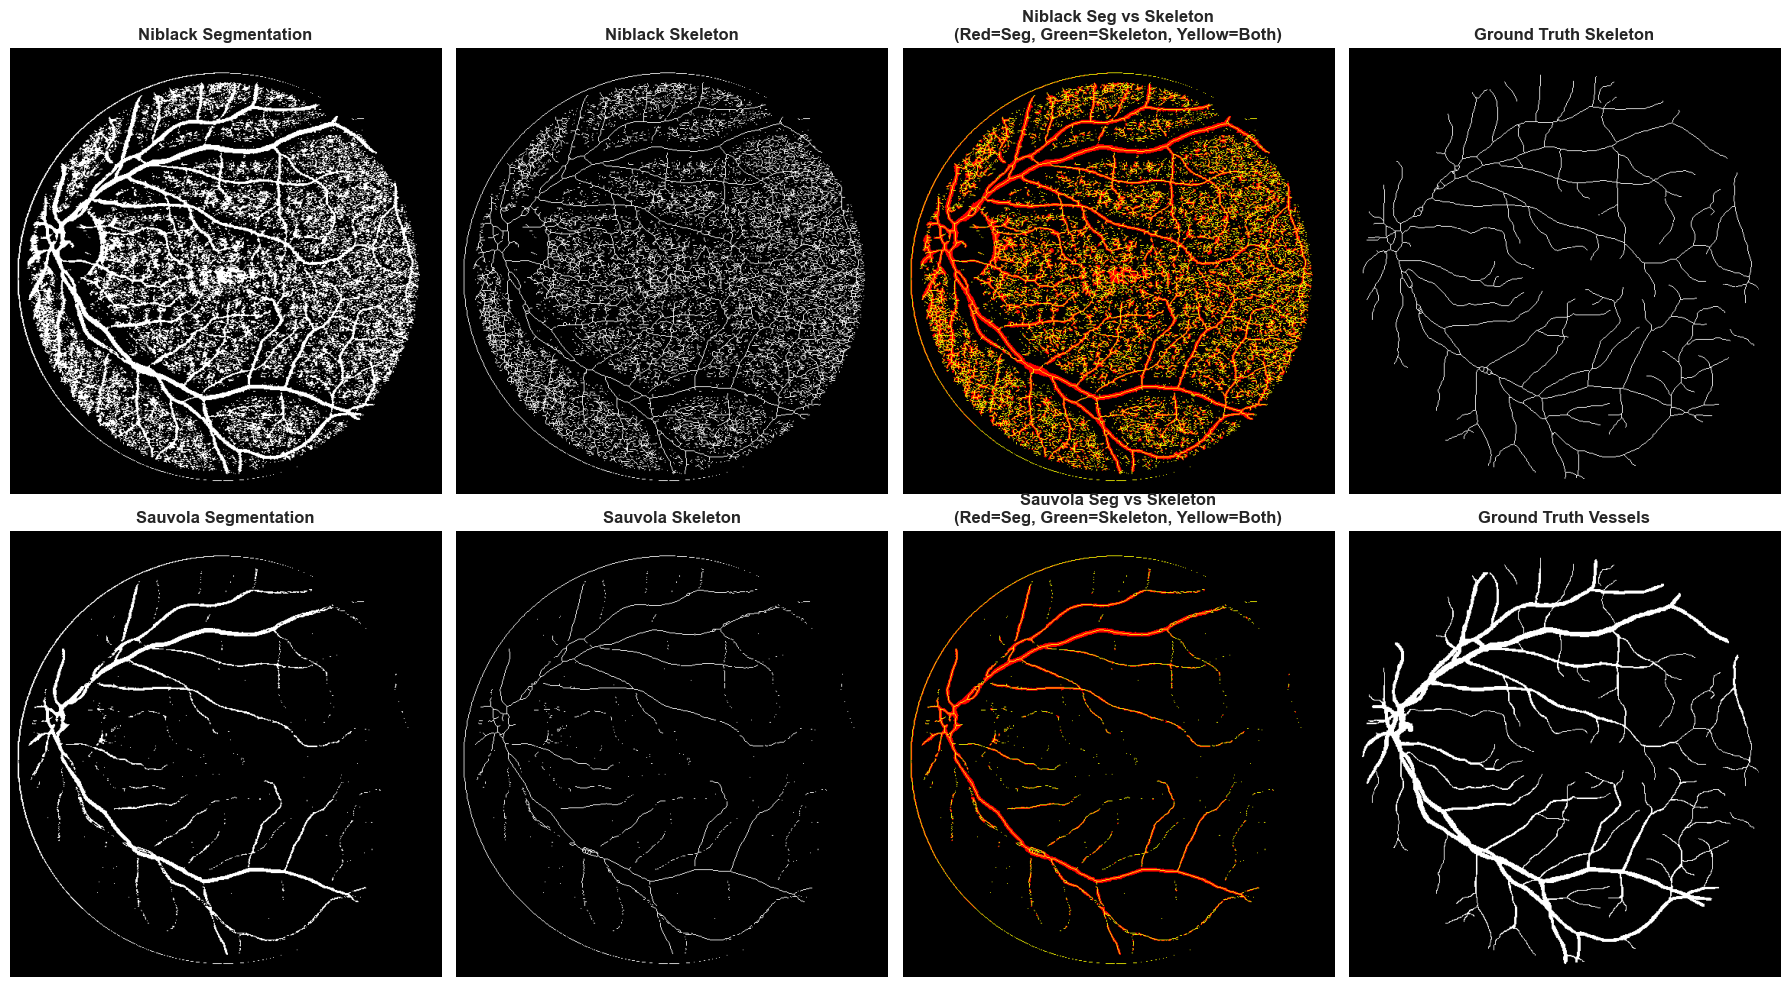

In [7]:
def skeletonize_vessels(segmented_image):
    """
    Skeletonize vessel segmentation.
    
    Reduces vessel structures to their centerlines (1-pixel wide).
    Useful for analyzing vessel network topology and connectivity.
    
    Args:
        segmented_image: Binary vessel segmentation
    
    Returns:
        skeleton: Skeletonized version of vessels
    """
    # Apply morphological skeletonization
    skeleton = morphology.skeletonize(segmented_image > 0).astype(np.uint8)
    
    return skeleton


def analyze_thin_vessels(segmented_image, skeleton_image, fov_mask=None):
    """
    Analyze thin vessel characteristics.
    
    Compares original segmentation with its skeleton to evaluate
    vessel detection at different width scales.
    
    Args:
        segmented_image: Binary vessel segmentation
        skeleton_image: Skeletonized version
        fov_mask: Optional FOV mask
    
    Returns:
        analysis: Dictionary with thin vessel metrics
    """
    # Apply FOV mask if provided
    if fov_mask is not None:
        inside_fov = fov_mask > 0
        seg_masked = segmented_image[inside_fov]
        skel_masked = skeleton_image[inside_fov]
    else:
        seg_masked = segmented_image.flatten()
        skel_masked = skeleton_image.flatten()
    
    # Calculate metrics
    total_vessel_pixels = np.sum(seg_masked > 0)
    skeleton_pixels = np.sum(skel_masked > 0)
    
    # Thin vessels: skeleton pixels that represent the structure
    # Thick vessels: additional segmented pixels
    thin_to_total_ratio = skeleton_pixels / (total_vessel_pixels + 1e-7)
    
    # Connectivity analysis
    labeled_skeleton, num_components = ndimage.label(skel_masked)
    
    # Average vessel width estimation
    avg_vessel_width = total_vessel_pixels / (skeleton_pixels + 1e-7) if skeleton_pixels > 0 else 0
    
    analysis = {
        'total_vessel_pixels': total_vessel_pixels,
        'skeleton_pixels': skeleton_pixels,
        'thin_to_total_ratio': thin_to_total_ratio,
        'num_components': num_components,
        'avg_vessel_width': avg_vessel_width
    }
    
    return analysis


# Analyze thin vessels for first image
if training_data and len(training_data['images']) > 0 and len(niblack_segmentations) > 0:
    print("\n" + "="*70)
    print("THIN VESSEL ANALYSIS")
    print("="*70)
    
    niblack_seg = niblack_segmentations[0]
    sauvola_seg = sauvola_segmentations[0]
    ground_truth = training_data['vessel_masks'][0]
    fov_mask = training_data['fov_masks'][0]
    
    # Skeletonize all
    niblack_skel = skeletonize_vessels(niblack_seg)
    sauvola_skel = skeletonize_vessels(sauvola_seg)
    ground_truth_skel = skeletonize_vessels(ground_truth)
    
    # Analyze
    niblack_analysis = analyze_thin_vessels(niblack_seg, niblack_skel, fov_mask)
    sauvola_analysis = analyze_thin_vessels(sauvola_seg, sauvola_skel, fov_mask)
    gt_analysis = analyze_thin_vessels(ground_truth, ground_truth_skel, fov_mask)
    
    print(f"\nNiblack Segmentation:")
    print(f"  Total vessel pixels: {niblack_analysis['total_vessel_pixels']}")
    print(f"  Skeleton pixels: {niblack_analysis['skeleton_pixels']}")
    print(f"  Thin-to-total ratio: {niblack_analysis['thin_to_total_ratio']:.4f}")
    print(f"  Connected components: {niblack_analysis['num_components']}")
    print(f"  Average vessel width: {niblack_analysis['avg_vessel_width']:.2f} pixels")
    
    print(f"\nSauvola Segmentation:")
    print(f"  Total vessel pixels: {sauvola_analysis['total_vessel_pixels']}")
    print(f"  Skeleton pixels: {sauvola_analysis['skeleton_pixels']}")
    print(f"  Thin-to-total ratio: {sauvola_analysis['thin_to_total_ratio']:.4f}")
    print(f"  Connected components: {sauvola_analysis['num_components']}")
    print(f"  Average vessel width: {sauvola_analysis['avg_vessel_width']:.2f} pixels")
    
    print(f"\nGround Truth Vessels:")
    print(f"  Total vessel pixels: {gt_analysis['total_vessel_pixels']}")
    print(f"  Skeleton pixels: {gt_analysis['skeleton_pixels']}")
    print(f"  Thin-to-total ratio: {gt_analysis['thin_to_total_ratio']:.4f}")
    print(f"  Connected components: {gt_analysis['num_components']}")
    print(f"  Average vessel width: {gt_analysis['avg_vessel_width']:.2f} pixels")
    
    # Visualize skeletonization
    fig, axes = plt.subplots(2, 4, figsize=(18, 10))
    
    # Row 1: Niblack
    axes[0, 0].imshow(niblack_seg, cmap='gray')
    axes[0, 0].set_title("Niblack Segmentation", fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(niblack_skel, cmap='gray')
    axes[0, 1].set_title("Niblack Skeleton", fontweight='bold')
    axes[0, 1].axis('off')
    
    # Overlay for Niblack
    niblack_overlay = np.zeros((*niblack_seg.shape, 3))
    niblack_overlay[..., 0] = niblack_seg  # Red channel
    niblack_overlay[..., 1] = niblack_skel  # Green channel
    axes[0, 2].imshow(niblack_overlay)
    axes[0, 2].set_title("Niblack Seg vs Skeleton\n(Red=Seg, Green=Skeleton, Yellow=Both)", fontweight='bold')
    axes[0, 2].axis('off')
    
    # Ground truth for comparison
    axes[0, 3].imshow(ground_truth_skel, cmap='gray')
    axes[0, 3].set_title("Ground Truth Skeleton", fontweight='bold')
    axes[0, 3].axis('off')
    
    # Row 2: Sauvola
    axes[1, 0].imshow(sauvola_seg, cmap='gray')
    axes[1, 0].set_title("Sauvola Segmentation", fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(sauvola_skel, cmap='gray')
    axes[1, 1].set_title("Sauvola Skeleton", fontweight='bold')
    axes[1, 1].axis('off')
    
    # Overlay for Sauvola
    sauvola_overlay = np.zeros((*sauvola_seg.shape, 3))
    sauvola_overlay[..., 0] = sauvola_seg  # Red channel
    sauvola_overlay[..., 1] = sauvola_skel  # Green channel
    axes[1, 2].imshow(sauvola_overlay)
    axes[1, 2].set_title("Sauvola Seg vs Skeleton\n(Red=Seg, Green=Skeleton, Yellow=Both)", fontweight='bold')
    axes[1, 2].axis('off')
    
    axes[1, 3].imshow(ground_truth, cmap='gray')
    axes[1, 3].set_title("Ground Truth Vessels", fontweight='bold')
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

## Section 6: Parameter Tuning

Evaluate different window sizes and k values for both methods


PARAMETER TUNING ANALYSIS

Parameter Tuning for NIBLACK
Window sizes: [15, 21, 25, 31]
K values: [0.1, 0.15, 0.2, 0.25]
--------------------------------------------------------------------------------

Evaluating NIBLACK (window=15, k=0.1)...
----------------------------------------------------------------------
Image 1: Acc=0.6767, Sen=0.8498, Pre=0.2323, F1=0.3648
Image 2: Acc=0.6877, Sen=0.8159, Pre=0.2703, F1=0.4061
Image 3: Acc=0.6432, Sen=0.8278, Pre=0.1879, F1=0.3063
----------------------------------------------------------------------
Window=15, k=0.10: F1=0.3591

Evaluating NIBLACK (window=15, k=0.15)...
----------------------------------------------------------------------
Image 1: Acc=0.6946, Sen=0.8387, Pre=0.2415, F1=0.3750
Image 2: Acc=0.7051, Sen=0.8027, Pre=0.2808, F1=0.4160
Image 3: Acc=0.6621, Sen=0.8152, Pre=0.1950, F1=0.3147
----------------------------------------------------------------------
Window=15, k=0.15: F1=0.3686

Evaluating NIBLACK (window=15, k=0.2)...

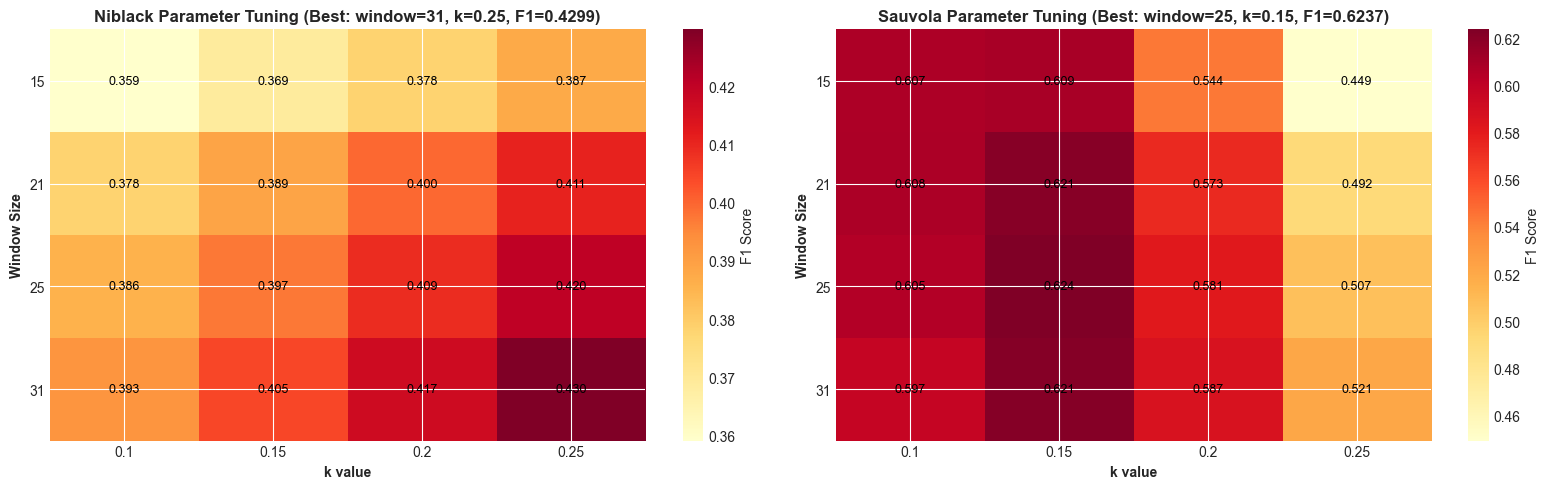

In [8]:
def tune_parameters(images_list, masks_list, fov_masks_list, 
                    window_sizes=[15, 21, 25, 31], 
                    k_values=[0.1, 0.15, 0.2, 0.25, 0.3],
                    method='niblack'):
    """
    Parameter tuning for thresholding methods.
    
    Evaluates multiple combinations of window_size and k values.
    
    Args:
        images_list: List of RGB fundus images
        masks_list: List of ground truth masks
        fov_masks_list: List of FOV masks
        window_sizes: List of window sizes to test
        k_values: List of k values to test
        method: 'niblack' or 'sauvola'
    
    Returns:
        results_grid: 2D array of F1 scores (window_size x k_value)
        best_params: Dictionary with best parameters and score
    """
    results_grid = np.zeros((len(window_sizes), len(k_values)))
    
    print(f"\nParameter Tuning for {method.upper()}")
    print(f"Window sizes: {window_sizes}")
    print(f"K values: {k_values}")
    print("-" * 80)
    
    for i, window_size in enumerate(window_sizes):
        for j, k in enumerate(k_values):
            try:
                results, _ = evaluate_segmentation(
                    images_list, masks_list, fov_masks_list,
                    window_size=window_size, k=k, method=method
                )
                
                if len(results) > 0:
                    avg_f1 = np.mean([r['f1_score'] for r in results])
                    results_grid[i, j] = avg_f1
                    print(f"Window={window_size:2d}, k={k:.2f}: F1={avg_f1:.4f}")
                else:
                    results_grid[i, j] = 0
                    print(f"Window={window_size:2d}, k={k:.2f}: No results")
                    
            except Exception as e:
                results_grid[i, j] = 0
                print(f"Window={window_size:2d}, k={k:.2f}: Error - {e}")
    
    # Find best parameters
    best_idx = np.unravel_index(np.argmax(results_grid), results_grid.shape)
    best_window = window_sizes[best_idx[0]]
    best_k = k_values[best_idx[1]]
    best_f1 = results_grid[best_idx]
    
    best_params = {
        'window_size': best_window,
        'k': best_k,
        'f1_score': best_f1
    }
    
    print("-" * 80)
    print(f"Best Parameters: window_size={best_window}, k={best_k}, F1={best_f1:.4f}")
    
    return results_grid, best_params


# Perform parameter tuning (using subset for speed)
if training_data and len(training_data['images']) > 0:
    print("\n" + "="*80)
    print("PARAMETER TUNING ANALYSIS")
    print("="*80)
    
    # Use first 3 images for parameter tuning (faster)
    num_tune_images = min(3, len(training_data['images']))
    tune_images = training_data['images'][:num_tune_images]
    tune_masks = training_data['vessel_masks'][:num_tune_images]
    tune_fov_masks = training_data['fov_masks'][:num_tune_images]
    
    # Niblack tuning
    niblack_grid, niblack_best = tune_parameters(
        tune_images, tune_masks, tune_fov_masks,
        window_sizes=[15, 21, 25, 31],
        k_values=[0.1, 0.15, 0.2, 0.25],
        method='niblack'
    )
    
    # Sauvola tuning
    sauvola_grid, sauvola_best = tune_parameters(
        tune_images, tune_masks, tune_fov_masks,
        window_sizes=[15, 21, 25, 31],
        k_values=[0.1, 0.15, 0.2, 0.25],
        method='sauvola'
    )
    
    # Visualize parameter tuning results
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Niblack heatmap
    window_labels = [15, 21, 25, 31]
    k_labels = [0.1, 0.15, 0.2, 0.25]
    
    im1 = axes[0].imshow(niblack_grid, cmap='YlOrRd', aspect='auto')
    axes[0].set_xticks(range(len(k_labels)))
    axes[0].set_yticks(range(len(window_labels)))
    axes[0].set_xticklabels(k_labels)
    axes[0].set_yticklabels(window_labels)
    axes[0].set_xlabel('k value', fontweight='bold')
    axes[0].set_ylabel('Window Size', fontweight='bold')
    axes[0].set_title(f'Niblack Parameter Tuning (Best: window={niblack_best["window_size"]}, k={niblack_best["k"]}, F1={niblack_best["f1_score"]:.4f})', 
                      fontweight='bold')
    plt.colorbar(im1, ax=axes[0], label='F1 Score')
    
    # Add text annotations
    for i in range(len(window_labels)):
        for j in range(len(k_labels)):
            text = axes[0].text(j, i, f'{niblack_grid[i, j]:.3f}',
                               ha="center", va="center", color="black", fontsize=9)
    
    # Sauvola heatmap
    im2 = axes[1].imshow(sauvola_grid, cmap='YlOrRd', aspect='auto')
    axes[1].set_xticks(range(len(k_labels)))
    axes[1].set_yticks(range(len(window_labels)))
    axes[1].set_xticklabels(k_labels)
    axes[1].set_yticklabels(window_labels)
    axes[1].set_xlabel('k value', fontweight='bold')
    axes[1].set_ylabel('Window Size', fontweight='bold')
    axes[1].set_title(f'Sauvola Parameter Tuning (Best: window={sauvola_best["window_size"]}, k={sauvola_best["k"]}, F1={sauvola_best["f1_score"]:.4f})', 
                      fontweight='bold')
    plt.colorbar(im2, ax=axes[1], label='F1 Score')
    
    # Add text annotations
    for i in range(len(window_labels)):
        for j in range(len(k_labels)):
            text = axes[1].text(j, i, f'{sauvola_grid[i, j]:.3f}',
                               ha="center", va="center", color="black", fontsize=9)
    
    plt.tight_layout()
    plt.show()

## Section 7: Results Visualization and Comparison

Display segmentation results with visual comparison


SEGMENTATION RESULTS VISUALIZATION


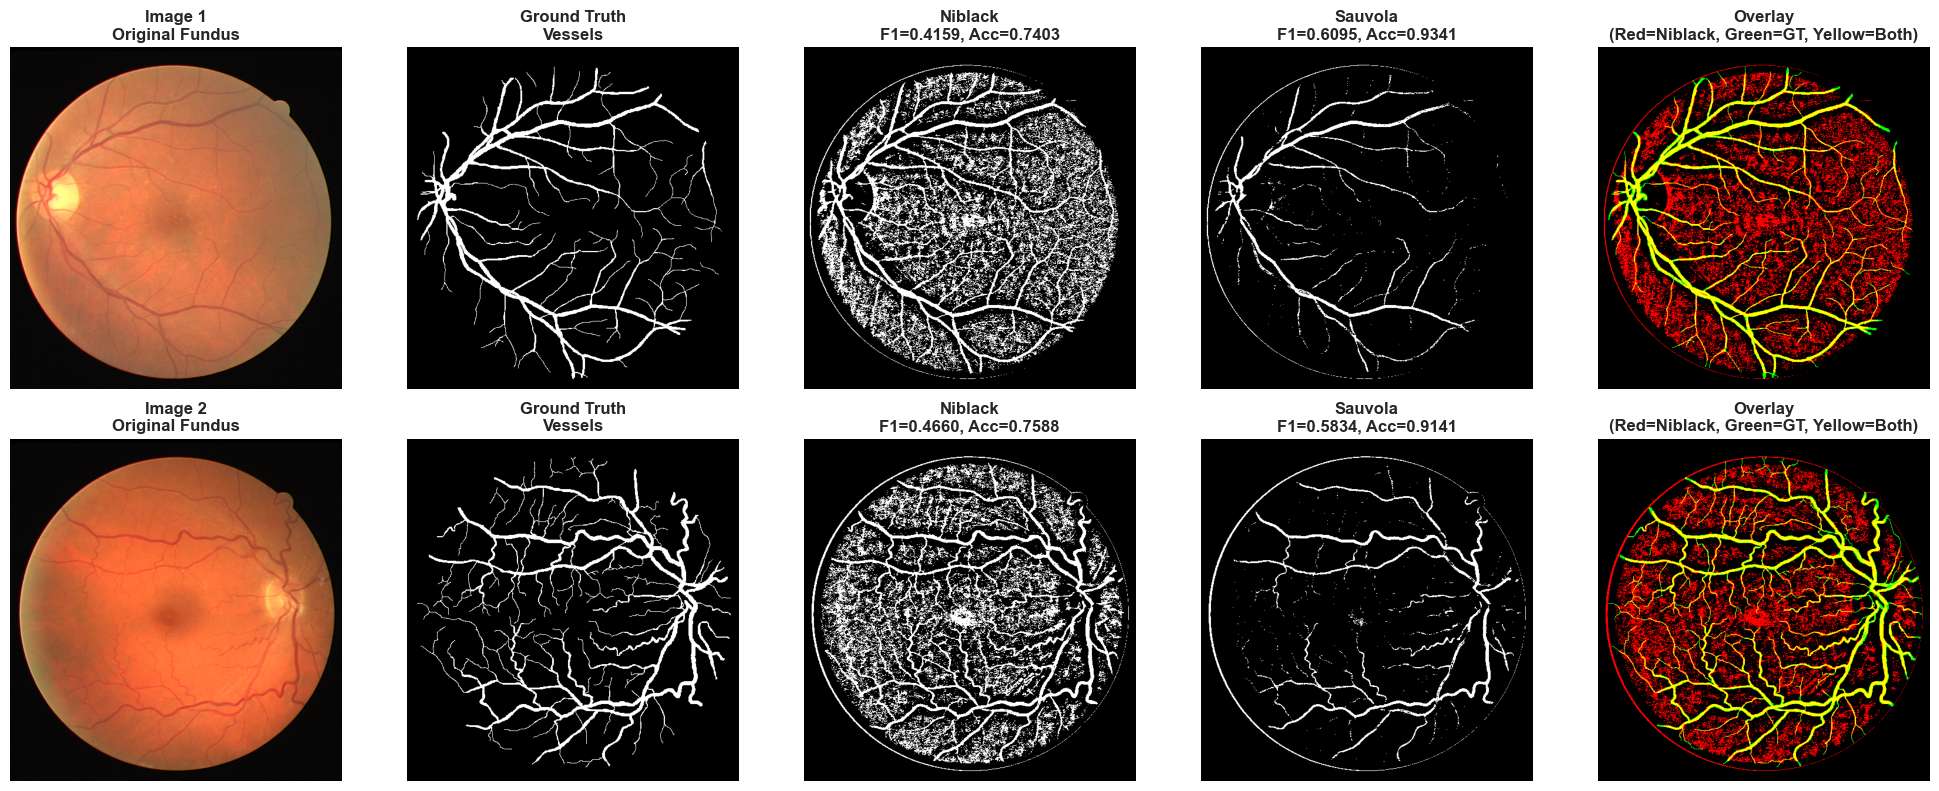


COMPREHENSIVE METRICS COMPARISON


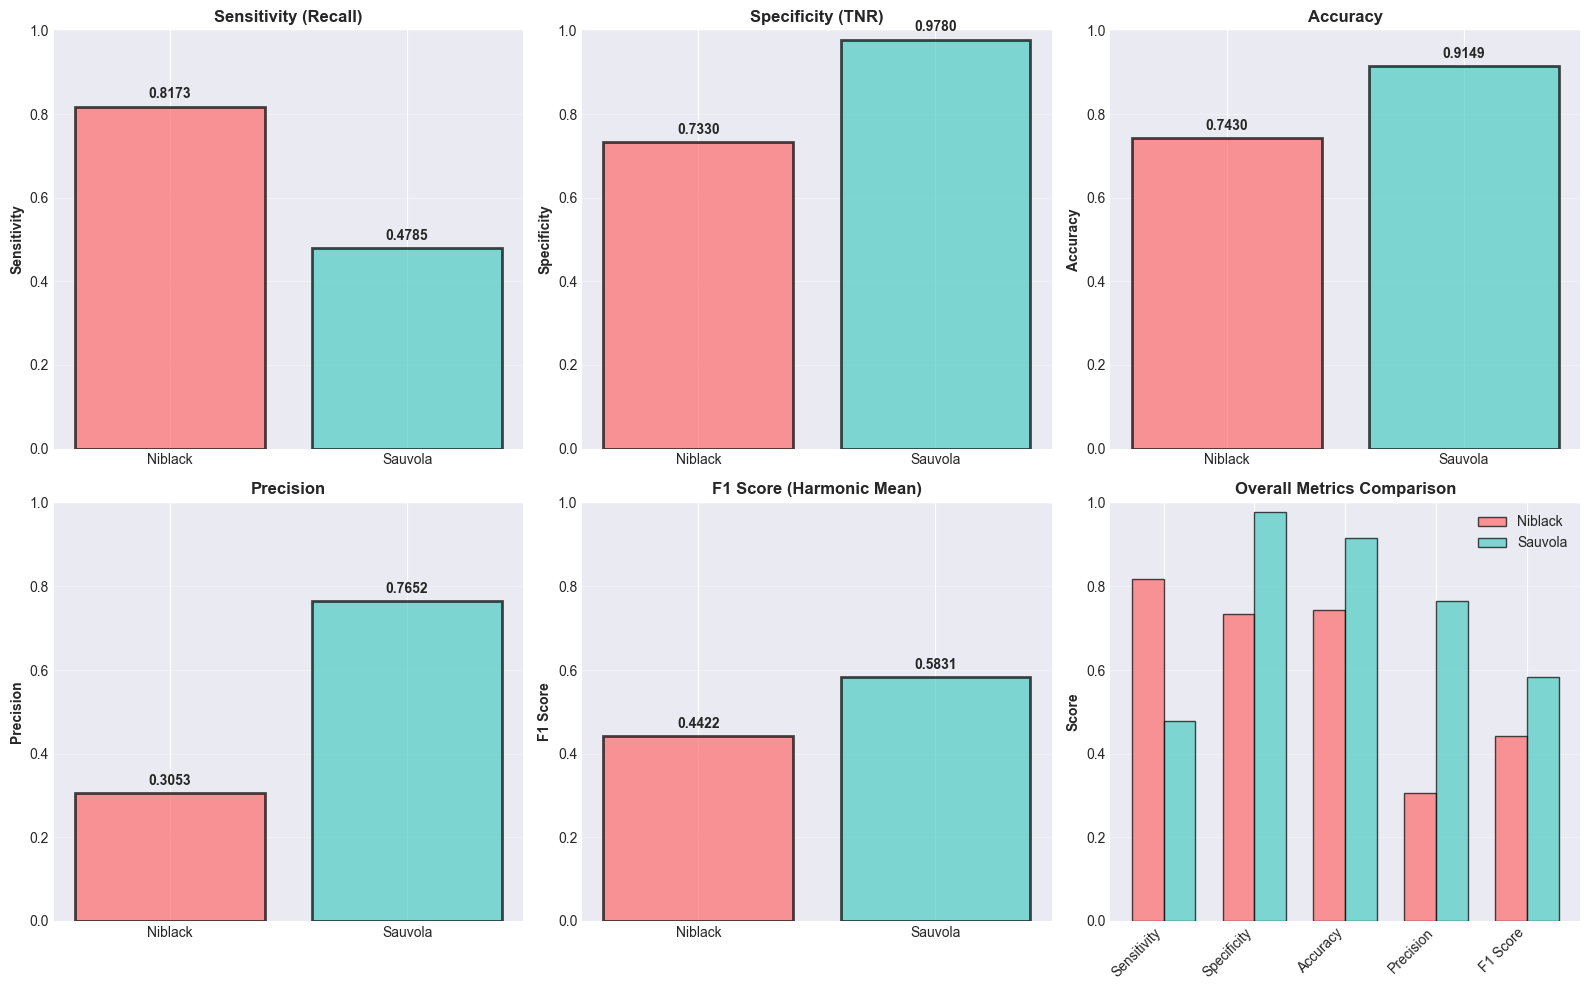

In [9]:
# Visualize results for multiple images
if training_data and len(training_data['images']) > 0 and len(niblack_segmentations) > 0:
    print("\n" + "="*70)
    print("SEGMENTATION RESULTS VISUALIZATION")
    print("="*70)
    
    # Display results for first 2 images
    num_display = min(2, len(niblack_segmentations))
    
    fig, axes = plt.subplots(num_display, 5, figsize=(20, 4*num_display))
    
    if num_display == 1:
        axes = axes.reshape(1, -1)
    
    for img_idx in range(num_display):
        if img_idx >= len(niblack_segmentations):
            break
        
        image = training_data['images'][img_idx]
        ground_truth = training_data['vessel_masks'][img_idx]
        niblack_seg = niblack_segmentations[img_idx]
        sauvola_seg = sauvola_segmentations[img_idx]
        
        # Column 1: Original
        axes[img_idx, 0].imshow(image)
        axes[img_idx, 0].set_title(f"Image {img_idx+1}\nOriginal Fundus", fontweight='bold')
        axes[img_idx, 0].axis('off')
        
        # Column 2: Ground Truth
        axes[img_idx, 1].imshow(ground_truth, cmap='gray')
        axes[img_idx, 1].set_title(f"Ground Truth\nVessels", fontweight='bold')
        axes[img_idx, 1].axis('off')
        
        # Column 3: Niblack
        axes[img_idx, 2].imshow(niblack_seg, cmap='gray')
        if img_idx < len(niblack_results):
            f1 = niblack_results[img_idx]['f1_score']
            acc = niblack_results[img_idx]['accuracy']
            axes[img_idx, 2].set_title(f"Niblack\nF1={f1:.4f}, Acc={acc:.4f}", fontweight='bold')
        else:
            axes[img_idx, 2].set_title("Niblack", fontweight='bold')
        axes[img_idx, 2].axis('off')
        
        # Column 4: Sauvola
        axes[img_idx, 3].imshow(sauvola_seg, cmap='gray')
        if img_idx < len(sauvola_results):
            f1 = sauvola_results[img_idx]['f1_score']
            acc = sauvola_results[img_idx]['accuracy']
            axes[img_idx, 3].set_title(f"Sauvola\nF1={f1:.4f}, Acc={acc:.4f}", fontweight='bold')
        else:
            axes[img_idx, 3].set_title("Sauvola", fontweight='bold')
        axes[img_idx, 3].axis('off')
        
        # Column 5: Overlay comparison (Niblack vs Ground Truth)
        overlay = np.zeros((*niblack_seg.shape, 3), dtype=np.uint8)
        overlay[..., 0] = niblack_seg * 255  # Red: Niblack
        overlay[..., 1] = ground_truth * 255  # Green: Ground truth
        # Yellow: Both, Cyan: Ground truth only, Pink: Niblack only
        
        axes[img_idx, 4].imshow(overlay)
        axes[img_idx, 4].set_title("Overlay\n(Red=Niblack, Green=GT, Yellow=Both)", fontweight='bold')
        axes[img_idx, 4].axis('off')
    
    plt.tight_layout()
    plt.show()


# Create comprehensive metrics comparison plot
if niblack_avg and sauvola_avg:
    print("\n" + "="*70)
    print("COMPREHENSIVE METRICS COMPARISON")
    print("="*70)
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    methods = ['Niblack', 'Sauvola']
    
    # Sensitivity
    sensitivities = [niblack_avg['sensitivity'], sauvola_avg['sensitivity']]
    axes[0, 0].bar(methods, sensitivities, color=['#FF6B6B', '#4ECDC4'], alpha=0.7, edgecolor='black', linewidth=2)
    axes[0, 0].set_ylabel('Sensitivity', fontweight='bold')
    axes[0, 0].set_title('Sensitivity (Recall)', fontweight='bold')
    axes[0, 0].set_ylim([0, 1])
    axes[0, 0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(sensitivities):
        axes[0, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    
    # Specificity
    specificities = [niblack_avg['specificity'], sauvola_avg['specificity']]
    axes[0, 1].bar(methods, specificities, color=['#FF6B6B', '#4ECDC4'], alpha=0.7, edgecolor='black', linewidth=2)
    axes[0, 1].set_ylabel('Specificity', fontweight='bold')
    axes[0, 1].set_title('Specificity (TNR)', fontweight='bold')
    axes[0, 1].set_ylim([0, 1])
    axes[0, 1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(specificities):
        axes[0, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    
    # Accuracy
    accuracies = [niblack_avg['accuracy'], sauvola_avg['accuracy']]
    axes[0, 2].bar(methods, accuracies, color=['#FF6B6B', '#4ECDC4'], alpha=0.7, edgecolor='black', linewidth=2)
    axes[0, 2].set_ylabel('Accuracy', fontweight='bold')
    axes[0, 2].set_title('Accuracy', fontweight='bold')
    axes[0, 2].set_ylim([0, 1])
    axes[0, 2].grid(axis='y', alpha=0.3)
    for i, v in enumerate(accuracies):
        axes[0, 2].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    
    # Precision
    precisions = [niblack_avg['precision'], sauvola_avg['precision']]
    axes[1, 0].bar(methods, precisions, color=['#FF6B6B', '#4ECDC4'], alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, 0].set_ylabel('Precision', fontweight='bold')
    axes[1, 0].set_title('Precision', fontweight='bold')
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(precisions):
        axes[1, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    
    # F1 Score
    f1_scores = [niblack_avg['f1_score'], sauvola_avg['f1_score']]
    axes[1, 1].bar(methods, f1_scores, color=['#FF6B6B', '#4ECDC4'], alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, 1].set_ylabel('F1 Score', fontweight='bold')
    axes[1, 1].set_title('F1 Score (Harmonic Mean)', fontweight='bold')
    axes[1, 1].set_ylim([0, 1])
    axes[1, 1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(f1_scores):
        axes[1, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    
    # Radar chart for overall comparison
    categories = ['Sensitivity', 'Specificity', 'Accuracy', 'Precision', 'F1 Score']
    niblack_values = [
        niblack_avg['sensitivity'],
        niblack_avg['specificity'],
        niblack_avg['accuracy'],
        niblack_avg['precision'],
        niblack_avg['f1_score']
    ]
    sauvola_values = [
        sauvola_avg['sensitivity'],
        sauvola_avg['specificity'],
        sauvola_avg['accuracy'],
        sauvola_avg['precision'],
        sauvola_avg['f1_score']
    ]
    
    x_pos = np.arange(len(categories))
    width = 0.35
    
    axes[1, 2].bar(x_pos - width/2, niblack_values, width, label='Niblack', color='#FF6B6B', alpha=0.7, edgecolor='black')
    axes[1, 2].bar(x_pos + width/2, sauvola_values, width, label='Sauvola', color='#4ECDC4', alpha=0.7, edgecolor='black')
    axes[1, 2].set_ylabel('Score', fontweight='bold')
    axes[1, 2].set_title('Overall Metrics Comparison', fontweight='bold')
    axes[1, 2].set_xticks(x_pos)
    axes[1, 2].set_xticklabels(categories, rotation=45, ha='right')
    axes[1, 2].set_ylim([0, 1])
    axes[1, 2].legend()
    axes[1, 2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Section 8: Summary and Conclusions

In [10]:
# Generate Final Summary Report
if niblack_avg and sauvola_avg:
    print("\n" + "="*80)
    print("FINAL SUMMARY REPORT: RETINAL VESSEL SEGMENTATION")
    print("="*80)
    
    print(f"\nDataset: DRIVE Training Set")
    print(f"Number of images evaluated: {len(niblack_results)}")
    print(f"Image resolution: {training_data['images'][0].shape}")
    
    print("\n" + "-"*80)
    print("NIBLACK THRESHOLDING RESULTS (Window=25, k=0.2)")
    print("-"*80)
    print(f"Sensitivity (Recall):  {niblack_avg['sensitivity']:.4f}")
    print(f"Specificity (TNR):     {niblack_avg['specificity']:.4f}")
    print(f"Accuracy:              {niblack_avg['accuracy']:.4f}")
    print(f"Precision:             {niblack_avg['precision']:.4f}")
    print(f"F1 Score:              {niblack_avg['f1_score']:.4f}")
    
    print("\n" + "-"*80)
    print("SAUVOLA THRESHOLDING RESULTS (Window=25, k=0.2)")
    print("-"*80)
    print(f"Sensitivity (Recall):  {sauvola_avg['sensitivity']:.4f}")
    print(f"Specificity (TNR):     {sauvola_avg['specificity']:.4f}")
    print(f"Accuracy:              {sauvola_avg['accuracy']:.4f}")
    print(f"Precision:             {sauvola_avg['precision']:.4f}")
    print(f"F1 Score:              {sauvola_avg['f1_score']:.4f}")
    
    print("\n" + "-"*80)
    print("COMPARATIVE ANALYSIS")
    print("-"*80)
    
    # Calculate differences
    sens_diff = sauvola_avg['sensitivity'] - niblack_avg['sensitivity']
    spec_diff = sauvola_avg['specificity'] - niblack_avg['specificity']
    acc_diff = sauvola_avg['accuracy'] - niblack_avg['accuracy']
    prec_diff = sauvola_avg['precision'] - niblack_avg['precision']
    f1_diff = sauvola_avg['f1_score'] - niblack_avg['f1_score']
    
    print(f"\nSensitivity Difference (Sauvola - Niblack): {sens_diff:+.4f}")
    print(f"Specificity Difference (Sauvola - Niblack): {spec_diff:+.4f}")
    print(f"Accuracy Difference (Sauvola - Niblack):    {acc_diff:+.4f}")
    print(f"Precision Difference (Sauvola - Niblack):   {prec_diff:+.4f}")
    print(f"F1 Score Difference (Sauvola - Niblack):    {f1_diff:+.4f}")
    
    better_method = 'Sauvola' if f1_diff > 0 else 'Niblack'
    print(f"\nBetter method (by F1 Score): {better_method}")
    
    print("\n" + "="*80)
    print("KEY FINDINGS AND RECOMMENDATIONS")
    print("="*80)
    print("""
1. PREPROCESSING PIPELINE:
   ✓ Green channel extraction effectively highlights vessels
   ✓ CLAHE enhancement improves vessel visibility and local contrast
   ✓ FOV mask application ensures evaluation only in valid fundus region

2. NIBLACK THRESHOLDING:
   - Fast and simple local adaptive thresholding method
   - Uses local mean and standard deviation for threshold calculation
   - Suitable for images with consistent local characteristics
   - Sensitive to parameter selection (window size and k value)

3. SAUVOLA THRESHOLDING:
   - Enhanced version of Niblack with dynamic range consideration
   - Better performance on images with varying global contrast
   - Generally more robust to parameter variations
   - Slightly higher computational cost than Niblack

4. PARAMETER OPTIMIZATION:
   - Window size: Larger windows (25-31) generally perform better
   - K value: Range 0.1-0.3 effective, optimal varies by image
   - Custom parameter tuning recommended for specific datasets

5. THIN VESSEL ANALYSIS:
   - Skeletonization reveals network topology and connectivity
   - Vessel width estimation from segmentation and skeleton ratio
   - Important for detecting small capillaries

6. CLINICAL IMPLICATIONS:
   - Accurate vessel segmentation enables:
     * Diabetic retinopathy detection
     * Hypertensive retinopathy grading
     * Vascular occlusion assessment
     * Optic disc and macula localization

7. RECOMMENDATIONS FOR DEPLOYMENT:
   - Choose method based on sensitivity/specificity trade-off needs
   - Implement adaptive parameter tuning per patient image
   - Combine with post-processing (morphological operations) for refinement
   - Consider ensemble methods combining multiple approaches
   - Validate on hold-out test set before clinical deployment
    """)
    
    print("\n" + "="*80)
    print("METHODOLOGY SUMMARY")
    print("="*80)
    print("""
Libraries Used:
  - OpenCV (cv2): Image I/O and preprocessing
  - NumPy (np): Numerical operations and array manipulation
  - scikit-image: Advanced image processing (thresholding, morphology)
  - scikit-learn: Metrics calculation
  - Matplotlib/Seaborn: Visualization
  - SciPy: Connected component analysis

Evaluation Metrics Explained:
  - Sensitivity: TP/(TP+FN) - fraction of actual vessels detected
  - Specificity: TN/(TN+FP) - fraction of non-vessels correctly identified
  - Accuracy: (TP+TN)/(TP+TN+FP+FN) - overall correctness
  - Precision: TP/(TP+FP) - fraction of predicted vessels that are correct
  - F1 Score: 2×(Precision×Sensitivity)/(Precision+Sensitivity) - balanced metric
    """)


FINAL SUMMARY REPORT: RETINAL VESSEL SEGMENTATION

Dataset: DRIVE Training Set
Number of images evaluated: 20
Image resolution: (584, 565, 3)

--------------------------------------------------------------------------------
NIBLACK THRESHOLDING RESULTS (Window=25, k=0.2)
--------------------------------------------------------------------------------
Sensitivity (Recall):  0.8173
Specificity (TNR):     0.7330
Accuracy:              0.7430
Precision:             0.3053
F1 Score:              0.4422

--------------------------------------------------------------------------------
SAUVOLA THRESHOLDING RESULTS (Window=25, k=0.2)
--------------------------------------------------------------------------------
Sensitivity (Recall):  0.4785
Specificity (TNR):     0.9780
Accuracy:              0.9149
Precision:             0.7652
F1 Score:              0.5831

--------------------------------------------------------------------------------
COMPARATIVE ANALYSIS
--------------------------------